# This is a notebook to explore the ligpy results after solving the ODE model

Model results are saved by DDASAC in the format shown in the `ligpy/sample_results/` folder.  
Users that rely on a different ODE solver should format their results in the same way in order to use these analysis tools.

In [1]:
import copy
import csv

import numpy as np
import matplotlib.pyplot as plt           
import ipywidgets as widgets

import ligpy.ligpy_utils as utils
from ligpy.constants import MW
from ligpy.analysis_tools import load_results, tar_elem_analysis, C_fun_gen
from ligpy.analysis_tools import lump_species, generate_report

%matplotlib inline

### Choose the simulation results to analyze in this notebook

Users should specify the directory where their results are saved as a string object named `results_dir`.  
Then, select the folder you would like to analyze in this notebook by clicking it in the selection box.

In [2]:
# Absolute or relative path to the directory you've saved model results in
results_dir = 'ligpy/sample_results/'

results = !ls $results_dir
which_result = widgets.Select(options=results)
which_result

## Load the results from the chosen folder and generate a descriptive summary

In [3]:
# Load the program parameters and results from the selected folder
(end_time, output_time_step, initial_T, heating_rate, max_T, atol, rtol,
 plant, cool_time, y, t, T, specieslist, speciesindices,
 indices_to_species) = load_results(results_dir + which_result.value)

# If you want to make sure all species are present in the MW dictionary run this
# utils.check_species_in_MW(specieslist)

# create a new matrix of mass fractions (instead of concentrations)
m = copy.deepcopy(y)
for species in specieslist:
    # make an array of mass concentration (g/L)
    m[:, speciesindices[species]] = (y[:, speciesindices[species]] *
                                     MW[species][0])
# total mass at time 0
m_0 = m[0,:].sum(axis=0)
# The mass fractions
m /= m_0
# These two numbers should both be 1 if mass is conserved.  We know that some
# protons are not tracked in the model so this number should be close to 1
print '\nIf mass is conserved %s should equal %s\n'\
        % (m[0,:].sum(axis=0),m[-1,:].sum(axis=0))
    
t_index = generate_report(speciesindices, specieslist, y, m, t, which_result)

There is not a third DDASAC results file (cool down period)

If mass is conserved 1.0 should equal 0.997461710549


------------------------------------ REPORT ------------------------------------
Analysis of folder: Pseudotsuga_menziesii-max773K-162.0CperMin-1965.92592593end-0cool
Analysis done at the end of the entire simulation.

.............................. Elemental Analysis ..............................

Feedstock (wt%)  : 65.0% C    5.5% H   29.5% O
Bio-oil (wt%)    : 54.0% C    7.5% H   38.5% O

Feedstock (mol%) : 42.5% C   43.0% H   14.5% O
Bio-oil (mol%)   : 31.3% C   51.9% H   16.8% O

H:C ratio of tar = 1.66

Moisture content of tar (wt%) = 17.0%

............ Distribution of C-functional groups (shown as % of C) .............

                   Feedstock       Bio-oil         Heavy oil       Light oil       
C=O                4.93%           10.71%          8.92%           19.54%          
aromatic C-O       22.19%          14.91%          16.06%          9.26%       

### min/max mass fractions or concentrations for every species 
Un-comment out the appropriate block in this cell to see these reports

In [4]:
# # Concentrations
# print ('{0: <8}'.format('Species') + '\t' +
#        '{0: <14}'.format('Min Conc') + '\tMax Conc\n')
# for species in specieslist:
#     if np.nanmax(y[:, speciesindices[species]]) > 1e-5:
#         print ('%s\t%s\t%s' %
#                ('{0: <8}'.format(species),
#                 '{0: <14}'.format(np.nanmin(y[:, speciesindices[species]])),
#                 np.nanmax(y[:, speciesindices[species]])))

# # Mass fractions
# print ('{0: <8}'.format('Species') + '\t' +
#        '{0: <18}'.format('Min Mass Frac') + '\tMax Mass Frac\n')
# for species in specieslist:
#     if np.nanmax(m[:, speciesindices[species]]) > 1e-5:
#         print ('%s\t%s\t%s' % 
#                ('{: <8}'.format(species),
#                 '{: <18.2}'.format(np.nanmin(m[:, speciesindices[species]])),
#                 '{:}'.format(np.nanmax(m[:, speciesindices[species]]))))

## Visualizing the data
Here are some simple plots to start exploring the results

The code to make these plots is included here in the notebook instead of in `analysis_tools.py` because it is common to tweak a lot of the plot-generating code.

ligpy/analysis_tools.py:322: RuntimeWarning: invalid value encountered in divide
  C_fun /= C_fun.sum()


(array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45]),
 <a list of 10 Text yticklabel objects>)

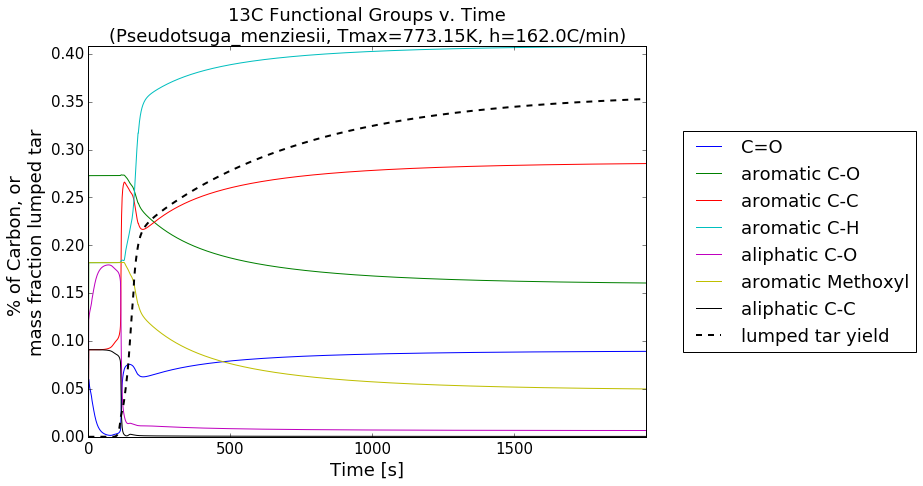

In [4]:
# Mass fraction of each 13C functional group vs. time
groups = ['C=O', 'aromatic C-O', 'aromatic C-C', 'aromatic C-H',
              'aliphatic C-O', 'aromatic Methoxyl', 'aliphatic C-C']
lumped, phenolic_families, morelumped = lump_species(speciesindices, m)
C13_array = np.zeros([7, len(t)])
for i, time in enumerate(t):
    C13_array[:, i] = C_fun_gen(['t'],speciesindices, y, time[0])
C13_array = np.nan_to_num(C13_array)

plt.figure(figsize=(10, 7), dpi=200)
for i in range(0, len(groups), 1):
    plt.plot(t[:], C13_array[i, :], label=groups[i])
    
# Add a line for the total lumped tar yield
plt.plot(t[:], morelumped[:, 1], label='lumped tar yield', color='black',
         linestyle='--', linewidth=2.0)

plt.axis([0, t[t_index], 0, np.max(C13_array)])
plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('% of Carbon, or \nmass fraction lumped tar', fontsize=18)
plt.title('13C Functional Groups v. Time\n(%s, Tmax=%sK, h=%sC/min)' % 
          (plant, max_T, heating_rate), fontsize=18)
plt.legend(ncol=1, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# # Write the model data for this figure to a csv file so plots can
# # be made in another notebook to use for publication.
# with open('pseudotsuga_menziesii_162_773.csv','wb') as csvfile:
#     modelwriter = csv.writer(csvfile)
#     modelwriter.writerows(np.concatenate((t.T, C13_array), axis=0).T)

Plot vs. temperature (y/n)?  (default is time) n
more or less lumped?  more


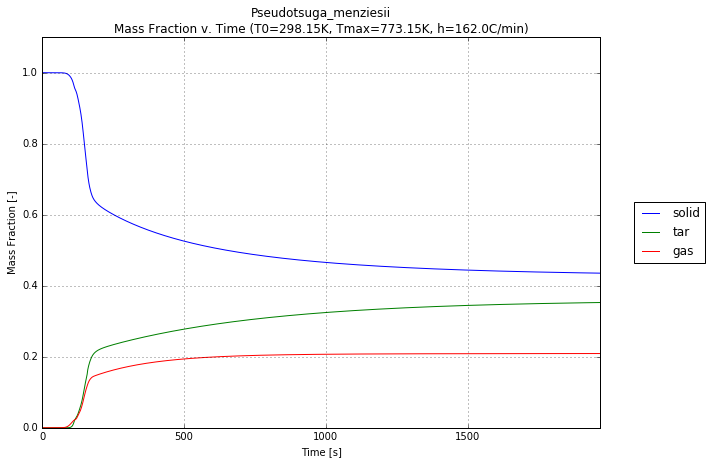

In [5]:
# Plot the mass fraction vs. time (or temperature) for the lumped species
Temp_plot = raw_input('Plot vs. temperature (y/n)?  (default is time) ')
# Temp_plot = 'y'
lump_level = raw_input('more or less lumped?  ')

if lump_level == 'more':
    plot_data = morelumped
else:
    plot_data = lumped

plt.figure(figsize=(10, 7), dpi=200)

if Temp_plot == 'y':
    # convert temperature from K to C
    Temperature = T - 273.15
    plt.plot(Temperature[:t_index], plot_data[:t_index, :])
    plt.xlabel('Temperature [C]')
    plt.title('%s\nMass Fraction v. Temperature (h=%sC/min)' %
              (plant, heating_rate))
    plt.axis([100, max(Temperature) * 1.05, np.nanmin(plot_data),
              1.1 * np.nanmax(plot_data)])
    plt.grid()
else:
    plt.plot(t[:t_index], plot_data[:t_index, :])
    plt.xlabel('Time [s]')
    plt.title('%s\nMass Fraction v. Time (T0=%sK, Tmax=%sK, h=%sC/min)' %
              (plant, initial_T, max_T, heating_rate))
    plt.axis([0, t[t_index] + 1, np.nanmin(plot_data),
              1.1 * np.nanmax(plot_data)])
    plt.grid()

if lump_level == 'more': 
    plt.legend(['solid', 'tar', 'gas'], ncol=1, loc='center left',
               bbox_to_anchor=(1.05, 0.5)) 
else: 
    plt.legend(['non-char solid', 'heavy tar', 'light tar', 'gas', 'CO',
                'CO2', 'H2O', 'char'], ncol=1, loc='center left',
               bbox_to_anchor=(1.05, 0.5))
    
plt.ylabel('Mass Fraction [-]')
# if saveplots == 'yes':
#     plt.savefig('/%s_mvT_%sK-to-%sK_%sCperMin.png' %
#                 (plant, initial_T, max_T, heating_rate),
#                 bbox_inches = 'tight')

Plot concentration vs temperature (y)?  Default is time. n


/usr/local/lib/python2.7/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


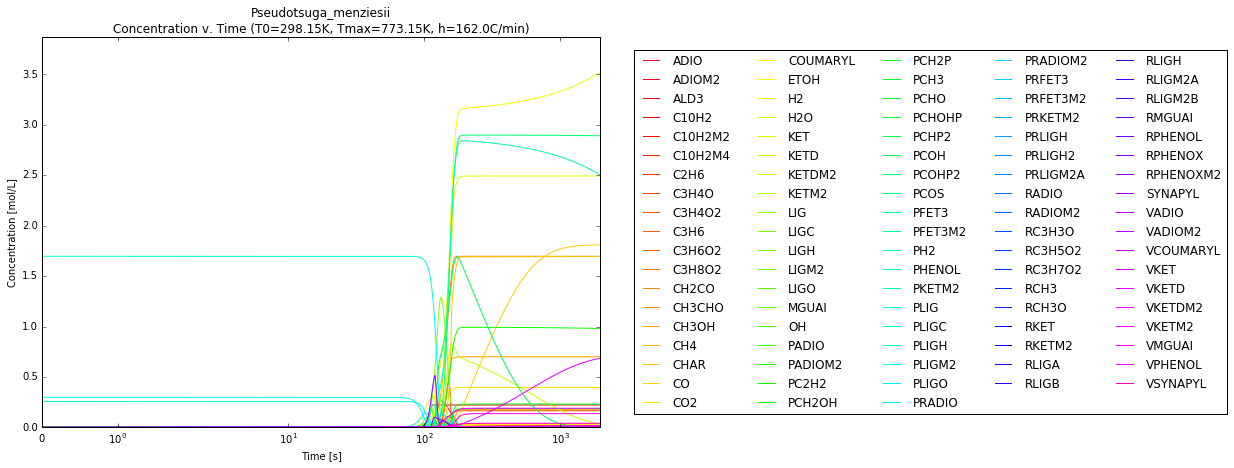

In [6]:
# Concentration vs Time or Temp for all species
tvT = raw_input('Plot concentration vs temperature (y)?  Default is time. ')

if tvT == 'y':
    # This plot shows the concentration vs. temperature for all species
    plt.figure(figsize=(10, 7), dpi=200)
    num_colors = len(specieslist)
    color_map = plt.get_cmap('gist_rainbow')
    plt.gca().set_color_cycle([color_map(1. * i / num_colors) 
                               for i in range(num_colors)])
    for i, species in enumerate(specieslist):
        color = color_map(1. * i / num_colors)
        plt.plot(T[:t_index], y[:t_index, speciesindices[species]],
                 label=species)
    plt.axis([T[0], T[t_index], np.nanmin(y), 1.1 * np.nanmax(y)])
    plt.xlabel('Temperature [K]')
    plt.ylabel('Concentration [mol/L]')
    plt.title('%s\nConcentration v. Temperature (T0=%sK, Tmax=%sK, h=%sC/min)'
              % (plant, initial_T, max_T, heating_rate))
    legend = plt.legend(ncol=5, loc='center left', bbox_to_anchor=(1.05, 0.5))
else: 
    # This plot shows the concentration vs. time for all species
    plt.figure(figsize=(10, 7), dpi=200)
    num_colors = len(specieslist)
    color_map = plt.get_cmap('gist_rainbow')
    plt.gca().set_color_cycle([color_map(1. * i / num_colors)
                               for i in range(num_colors)])
    for i, species in enumerate(specieslist):
        color = color_map(1. * i / num_colors)
        plt.plot(t[:], y[:, speciesindices[species]], label=species)

    plt.axis([0, t[t_index], np.nanmin(y), 1.1 * np.nanmax(y)])
    plt.xlabel('Time [s]')
    plt.ylabel('Concentration [mol/L]')
    plt.title('%s\nConcentration v. Time (T0=%sK, Tmax=%sK, h=%sC/min)'
              % (plant, initial_T, max_T, heating_rate))
    plt.legend(ncol=5, loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.xscale('symlog')
    

What is the min mass fraction of products you want to plot?  0.1

Minimum mass fraction is 0.1 at 1965.9259 sec and 773.15 K



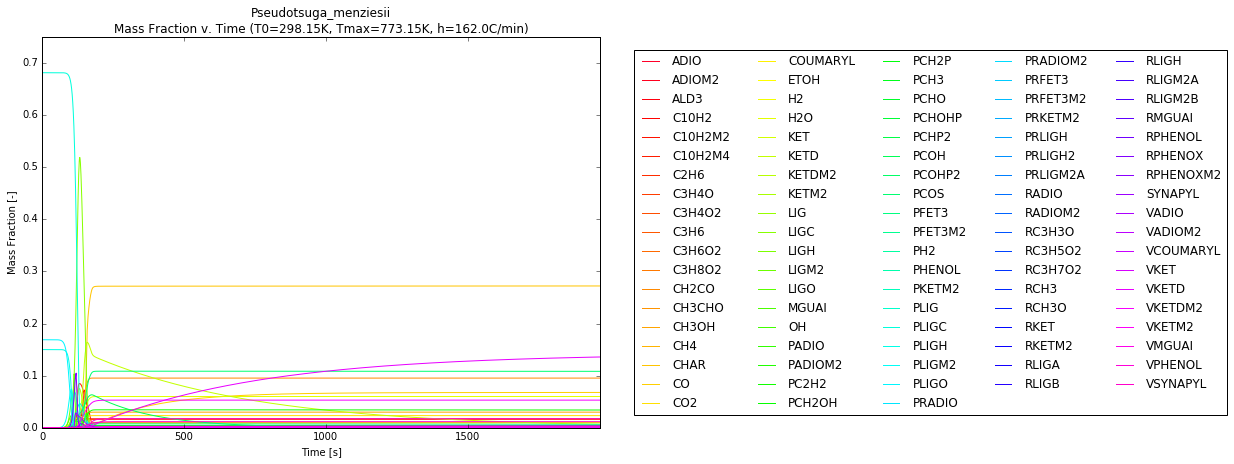

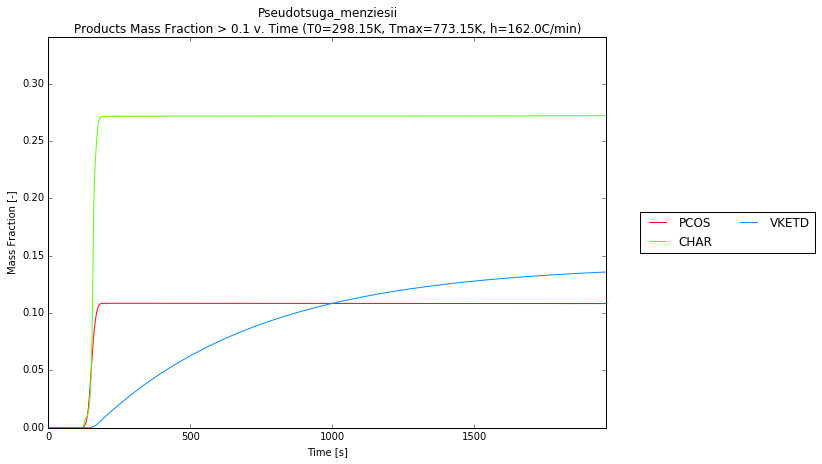

In [9]:
# Plot the mass fraction vs. time for all species
plt.figure(figsize=(10, 7), dpi=200)
num_colors = len(specieslist)
color_map = plt.get_cmap('gist_rainbow')
plt.gca().set_color_cycle([color_map(1. * i / num_colors)
                           for i in range(num_colors)])
for i,species in enumerate(specieslist):
    color = color_map(1. * i / num_colors)
    plt.plot(t, m[:, speciesindices[species]], label=species)

plt.axis([t[0], t[-1], 0, 1.1 * np.nanmax(m[:])])
plt.xlabel('Time [s]')
# plt.xscale('symlog')
plt.ylabel('Mass Fraction [-]')
plt.title('%s\nMass Fraction v. Time (T0=%sK, Tmax=%sK, h=%sC/min)'
          % (plant, initial_T, max_T, heating_rate))
legend = plt.legend(ncol=5, loc='center left', bbox_to_anchor=(1.05, 0.5))

# - Specify the minimum mass fraction at the end of the simulation to plot -
min_m = input('What is the min mass fraction of products you want to plot?  ')
products = []
for i, value in enumerate(m[t_index, :]):     
    if value > min_m: 
        products.append(indices_to_species[i])

print ('\nMinimum mass fraction is %s at %s sec and %s K\n'
       % (min_m, t[t_index][0], T[t_index][0]))
        
# This plot shows the mass fraction vs. time for those species above the min
plt.figure(figsize=(10, 7), dpi=200)
num_colors = len(products)
color_map = plt.get_cmap('gist_rainbow')
plt.gca().set_color_cycle([color_map(1. * i / num_colors)
                           for i in range(num_colors)])
for i, species in enumerate(products):   
    color = color_map(1. * i / num_colors)
    plt.plot(t[:t_index + 1], m[:t_index + 1, speciesindices[species]],
             label=species)
        
plt.axis([t[0], t[t_index], 0, 0.5 * np.nanmax(m[:])])
plt.xlabel('Time [s]')
plt.ylabel('Mass Fraction [-]')
plt.title('%s\nProducts Mass Fraction > %s v. Time (T0=%sK, Tmax=%sK, h=%sC/min)'
          % (plant, min_m, initial_T, max_T, heating_rate))
plt.legend(ncol=2, loc='center left', bbox_to_anchor=(1.05, 0.5))


Which species do you want to plot? RADIO
Do you want to plot concentration (c) or mass fraction (m) vs. Temp?  m


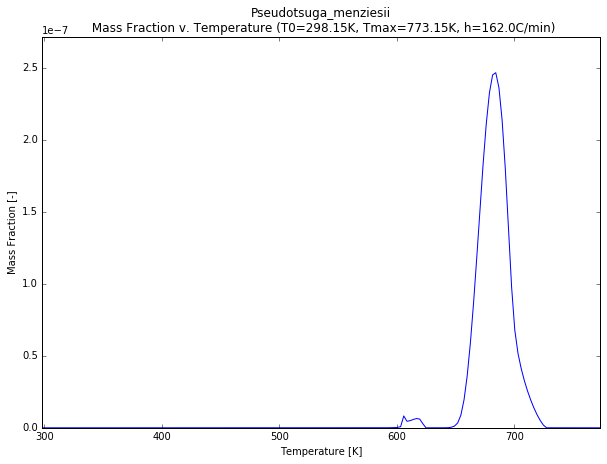

In [10]:
# Concentration or mass fraction vs. Temp for specific species 
specific = raw_input('Which species do you want to plot? ')
plot_type = raw_input('Do you want to plot concentration (c)'
                      ' or mass fraction (m) vs. Temp?  ')

plt.figure(figsize=(10, 7), dpi=200)
if plot_type == 'c': 
    plt.plot(T[:] ,y[:, speciesindices[specific]])
    plt.axis([T[0], np.max(T), 0,
              1.1 * np.nanmax(y[:, speciesindices[specific]])])
    plt.title('%s\n Concentration v. Temperature (T0=%sK, Tmax=%sK, h=%sC/min)'
              % (plant, initial_T, max_T, heating_rate))
    plt.xlabel('Temperature [K]')
    plt.ylabel('Concentration [mol/L]')
else:
    plt.plot(T[:], m[:, speciesindices[specific]])
    plt.axis([T[0], np.max(T), 0,
              1.1 * np.nanmax(m[:, speciesindices[specific]])])
    plt.title('%s\n Mass Fraction v. Temperature (T0=%sK, Tmax=%sK, h=%sC/min)'
              % (plant, initial_T, max_T, heating_rate))
    plt.xlabel('Temperature [K]')
    plt.ylabel('Mass Fraction [-]')

The max concentration in this simulation is 3.518145 mol/L. Cutoff for minimum concentration (mol/L)?  0.1

Minimum concentration is 0.1 mol/L at 1965.9259 sec



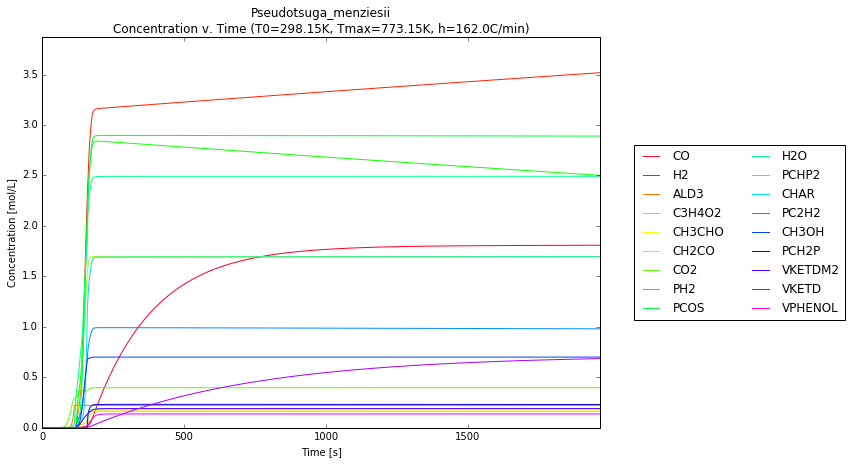

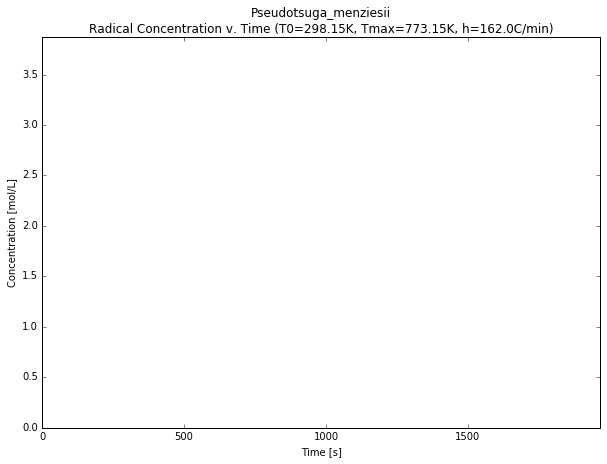

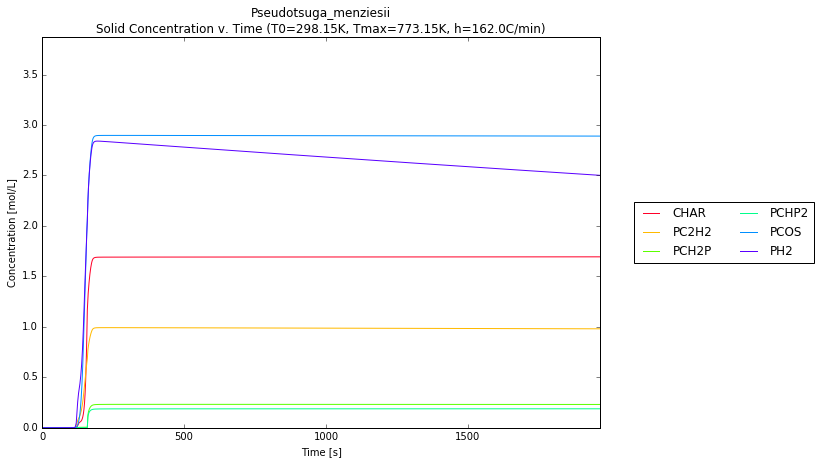

In [25]:
# Determine what species are present at the desired time in concentrations
# greater than specified.  The desired time is set by t_index in the code here.

# Specify the minimum concentration at the end of the simulation to plot
min_concentration = input('The max concentration in this simulation is %s '
                          'mol/L. Cutoff for minimum concentration (mol/L)?  '
                          % np.nanmax(y))

products = []
for i, value in enumerate(y[t_index, :]):     
    if value > min_concentration: 
        products.append(indices_to_species[i])

print ('\nMinimum concentration is %s mol/L at %s sec\n'
       % (min_concentration, t[t_index][0]))
        
# Plot concentration vs. time for those species from the list above
plt.figure(figsize=(10, 7), dpi=200)
num_colors = len(products)
color_map = plt.get_cmap('gist_rainbow')
plt.gca().set_color_cycle([color_map(1. * i / num_colors)
                           for i in range(num_colors)])
for i, species in enumerate(products):   
    color = color_map(1. * i / num_colors)
    plt.plot(t[:t_index + 1], y[:t_index + 1, speciesindices[species]],
             label=species)
    
    
plt.axis([t[0], t[t_index], np.nanmin(y), 1.1 * np.nanmax(y)])
plt.xlabel('Time [s]')
plt.ylabel('Concentration [mol/L]')
plt.title('%s\nConcentration v. Time (T0=%sK, Tmax=%sK, h=%sC/min)' %
          (plant, initial_T, max_T, heating_rate))
plt.legend(ncol=2, loc='center left', bbox_to_anchor=(1.05, 0.5))

# This plot shows the concentrations of radical species over time
radicalspecies = ['OH']
for i, species in enumerate(specieslist):
    if 'R'in species[0:2]:
        radicalspecies.append(species)
        
# The list of radical species with concentrations over the minimum specified value
radicals = []    
for species in radicalspecies:
    if species in products:
        radicals.append(species)

plt.figure(figsize=(10, 7), dpi=200)
num_colors = len(radicals)
color_map = plt.get_cmap('gist_rainbow')
plt.gca().set_color_cycle([color_map(1. * i / num_colors)
                           for i in range(num_colors)])
for i, species in enumerate(radicals):
    color = color_map(1. * i / num_colors)
    plt.plot(t[:t_index + 1], y[:t_index + 1, speciesindices[species]],
             label=species)

plt.xlabel('Time [s]')
plt.ylabel('Concentration [mol/L]')
plt.title('%s\nRadical Concentration v. Time (T0=%sK, Tmax=%sK, h=%sC/min)'
          % (plant, initial_T, max_T, heating_rate))
plt.axis([0, t[t_index], 0.9 * np.nanmin(y[:, :]), 1.1 * np.nanmax(y[:, :])])
plt.legend(ncol=2, loc='center left', bbox_to_anchor=(1.05, 0.5))

# This plot shows the concentrations of solid species > min value over time
solidspecies = ['CHAR']
for i, species in enumerate(specieslist):
    if MW[species][1] == 's':
        solidspecies.append(species)

# The list of solid species with concs over the minimum specified value
solidsp = []    
for species in solidspecies:
    if species in products:
        solidsp.append(species)
        
plt.figure(figsize=(10, 7), dpi=200)
num_colors = len(solidsp)
color_map = plt.get_cmap('gist_rainbow')
plt.gca().set_color_cycle([color_map(1. * i / num_colors)
                           for i in range(num_colors)])
for i, species in enumerate(solidsp):
    color = color_map(1. * i / num_colors)
    plt.plot(t[:t_index + 1], y[:t_index + 1, speciesindices[species]],
             label=species)

plt.xlabel('Time [s]')
plt.ylabel('Concentration [mol/L]')
plt.title('%s\nSolid Concentration v. Time (T0=%sK, Tmax=%sK, h=%sC/min)'
          % (plant, initial_T, max_T, heating_rate))
plt.axis([0, t[t_index], 0.9 * np.nanmin(y[:, :]), 1.1 * np.nanmax(y[:, :])])
plt.legend(ncol=2, loc='center left', bbox_to_anchor=(1.05, 0.5))
